## Train model with InceptionV3 by removing top layer and adding our own top layer.

In [11]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import keras 
from keras.layers import Conv2D, MaxPool2D, Flatten, Activation, Dropout, Dense
from keras.models import Sequential
from keras import applications
from keras.activations import relu
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Model

from keras import callbacks
import keras.backend.tensorflow_backend as K
from keras.applications.inception_v3 import InceptionV3

from keras_utils import multi_gpu_model

In [14]:
img_width, img_height = 299, 299

train_data_dir= 'data/train'
validation_data_dir = 'data/validation'
top_model_weights_path = 'top_model_inceptionV3.h5'
# checkpoints_file_path = weights.{epoch:02d}-{val_loss:.2f}.hdf5

nb_train_samples = 5566
nb_validation_samples = 2099
epochs = 100
batch_size = 16
learning_rate = 0.001
momentum = 0.8

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [16]:
base_model = InceptionV3(include_top=False,weights='imagenet',input_shape=[299,299,3])
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.6))
top_model.add(Dense(1,activation='sigmoid'))
# top_model.load_weights(top_model_weights_path)
# model.add(top_model)
parallel_model = Model(inputs= base_model.inputs, outputs= top_model(base_model.outputs))

In [ ]:
# parallel_model = multi_gpu_model(model, gpus=2)
# above gives error : can not pickle module object.

parallel_model.compile(optimizer=optimizers.SGD(lr=learning_rate, momentum= momentum),
             metrics=['accuracy'],loss='binary_crossentropy')


train_datagen = ImageDataGenerator(rescale=1/255,zoom_range=0.2, 
                               shear_range=0.2,horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                target_size=[img_height,img_width],
                                                batch_size=batch_size, class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,target_size=[img_height,img_width],
                                                batch_size=batch_size, class_mode='binary')



# add callbacks
tb_callbacks = callbacks.TensorBoard(log_dir='./Graph/SGD_lr-0.001', write_graph=True, write_images=True)
nan_callbacks = callbacks.TerminateOnNaN()
model_checkpoints = callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

parallel_model.fit_generator(train_generator,steps_per_epoch=nb_train_samples // batch_size,epochs=epochs,
                             validation_data=validation_generator,validation_steps=nb_validation_samples // batch_size, 
                             callbacks = [tb_callbacks, nan_callbacks, model_checkpoints, 
                                          reduce_lr,early_stopping])

parallel_model.save("tuned_model_inceptionV3.h5")

### Pipeline to Show Results from trained model. 

In [1]:
%pylab inline
import urllib.request
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.image as mpimg
from PIL import Image

input_img_width = 299
input_img_height = 299
required_image_size =299

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [4]:
# load model
print("loading model and compiling")
# model = load_model('tuned_model_inceptionV3.h5')
model = load_model('tuned_model_inceptionV3.h5')
print("model compiled")

loading model and compiling


ResourceExhaustedError: OOM when allocating tensor with shape[131072,256]
	 [[Node: dense_10_2/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=1817909, _device="/job:localhost/replica:0/task:0/gpu:0"](dense_10_2/random_uniform/shape)]]

Caused by op 'dense_10_2/random_uniform/RandomUniform', defined at:
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-d6f3722d3b6e>", line 4, in <module>
    model = load_model('tuned_model_inceptionV3.h5')
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/models.py", line 239, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/models.py", line 313, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/layers/__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/engine/topology.py", line 2487, in from_config
    process_layer(layer_data)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/engine/topology.py", line 2473, in process_layer
    custom_objects=custom_objects)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/layers/__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/models.py", line 1214, in from_config
    model.add(layer)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/models.py", line 475, in add
    output_tensor = layer(self.outputs[0])
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/engine/topology.py", line 575, in __call__
    self.build(input_shapes[0])
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/layers/core.py", line 828, in build
    constraint=self.kernel_constraint)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/engine/topology.py", line 396, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/initializers.py", line 212, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3544, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 247, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/avinash/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[131072,256]
	 [[Node: dense_10_2/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=1817909, _device="/job:localhost/replica:0/task:0/gpu:0"](dense_10_2/random_uniform/shape)]]


In [ ]:
def predict(img):

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    img = img/255
    images = np.vstack([img])
    result = model.predict(images, batch_size=10)
    return result

def show_images_prediction(img_path):
    
    img = Image.open(img_path)

    img = img.resize((required_image_size,required_image_size), Image.ANTIALIAS)
    
    result = predict(img)
    
    if result >0.5:
        result = 1
    else:
        result = 0
    
    result_to_class= {1: 'Interior', 0: 'Exteriror'}
    result_text = result_to_class[result]
    
    img=mpimg.imread(pic_path)
    imgplot = plt.imshow(img)
    plt.title(result_text)
    plt.show()
    
def show_images_prediction_from_url(img_url):
    from PIL import Image
    import requests

    img = Image.open(requests.get(img_url, stream=True).raw)
    print(img)
    
    img = img.resize((required_image_size,required_image_size), Image.ANTIALIAS)
    
    result = predict(img)
    
    if result >0.5:
        result = 1
    else:
        result = 0
    
    result_to_class= {1: 'Interior', 0: 'Exteriror'}
    result_text = result_to_class[result]
    
    imgplot = plt.imshow(img)
    plt.title(result_text)
    plt.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F453F236630>


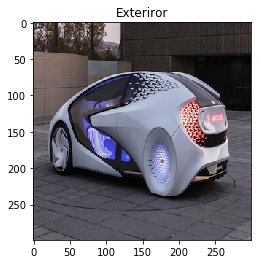

In [118]:
# url = 'https://i.pinimg.com/736x/4a/ab/ce/4aabce97526443cd72840b47ef842787--d%C3%A9cor-ideas-interior-ideas.jpg'
# url = 'https://previews.123rf.com/images/kurhan/kurhan1308/kurhan130800478/21684855-Car-interior-Auto-background--Stock-Photo.jpg'
# url = 'https://i.pinimg.com/564x/5f/06/b4/5f06b44457eda47ee8db94b3ea7f54bf--car-led-lights-interiors-led-car-lights-interior.jpg'
# url = 'https://i.ytimg.com/vi/xkD5aRFKx-o/maxresdefault.jpg'
# url = 'https://i.ytimg.com/vi/u4rJqm-AiPM/maxresdefault.jpg'
# url = 'https://cdn.vox-cdn.com/thumbor/xS7fj9wEumlZbc4nHVOLVowkDFc=/800x0/filters:no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/8048989/DSC03590.jpg'
url = 'https://i.ytimg.com/vi/NZ2FfO3-Lvw/maxresdefault.jpg'
img_path = '/home/avinash/Desktop/testing_Cars_images/000026.jpg'
show_images_prediction(img_path)